#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Цель - построить модель для предсказания количества заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Для достижения поставленной цели необходимо решить следующие задачи:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


<h1>Содержание<span class="tocSkip"></span></h1>
<li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-линейной-регрессии" data-toc-modified-id="Модель-линейной-регрессии-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель линейной регрессии</a></span></li><li><span><a href="#Модель-решающего-дерева" data-toc-modified-id="Модель-решающего-дерева-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель решающего дерева</a></span></li><li><span><a href="#Модель-XGBoost" data-toc-modified-id="Модель-XGBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель XGBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Модель-линейной-регрессии" data-toc-modified-id="Модель-линейной-регрессии-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Модель линейной регрессии</a></span></li><li><span><a href="#Модель-решающего-дерева" data-toc-modified-id="Модель-решающего-дерева-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Модель решающего дерева</a></span></li><li><span><a href="#Модель-XGBoost" data-toc-modified-id="Модель-XGBoost-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Модель XGBoost</a></span></li><li><span><a href="#Сравнение-графиков" data-toc-modified-id="Сравнение-графиков-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Сравнение графиков</a></span></li>

## Подготовка

In [53]:
# Импортируем все необходимые для работы библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [54]:
# Загрузим таблицу с данными
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [55]:
# Посмотрим на первые 10 строк нашей таблицы
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Видим, что в таблице имеется всего два столбца:

- datetime - время заказа (сразу через функцию index_col=[0] установили данный столбец в качестве индекса);
- num_orders - количество заказов.

In [56]:
# Посмотрим на общую информацию о таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверять данные на наличие дубликатов нет смысла, так как у нас остался один столбец, значения которого могут повторяться.

In [57]:
# Проверим, в хронологическом ли порядке расположены даты и время
df.index.is_monotonic

True

Данные расположены в хронологическом порядке.

In [58]:
# Проведем ресемплирование по одному часу
df = df.resample('1H').sum()

На первом этапе загрузили таблицу с данными, сразу изменив формат столбца с датой и временем на нужный тип данных и установив его в качестве индекса. Данные не требовали никакой дополнительной обработки. Затем провели ресемплирование с шагом в 1 час, агрегировав значения по сумме.

## Анализ

На данном этапе проведем анализ изменения количества заявок во времени.

Построим график получения заявок за весь интервал времени в разрезе их суммарного количества по часам.

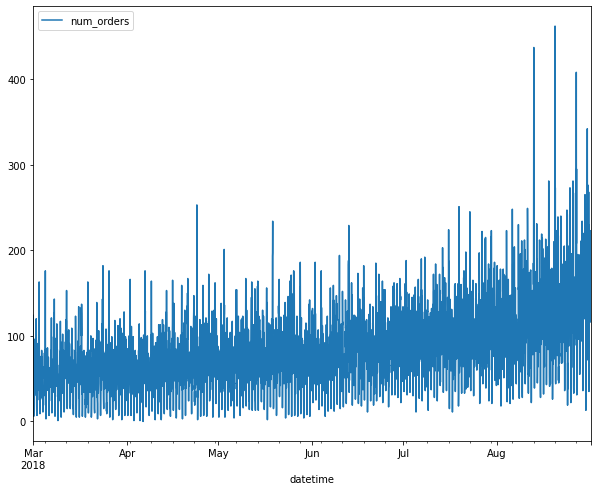

In [59]:
df.plot(figsize=(10, 8))
plt.show()

По данному графику сложно сделать какой-то вывод. На мой взгляд, стоит отметить большие колебания количества заявок, особенно начиная приблизительно с середины августа. 

Чтобы лучше понимать временной ряд, разложим его на тренд и сезонную компоненту.

In [60]:
# Функция для построения графиков
def plots(data):

    # График тренда
    decomposed = seasonal_decompose(data)
    plt.figure(figsize=(10, 8))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    # График сезонности
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    # График остатков
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()
    plt.show()

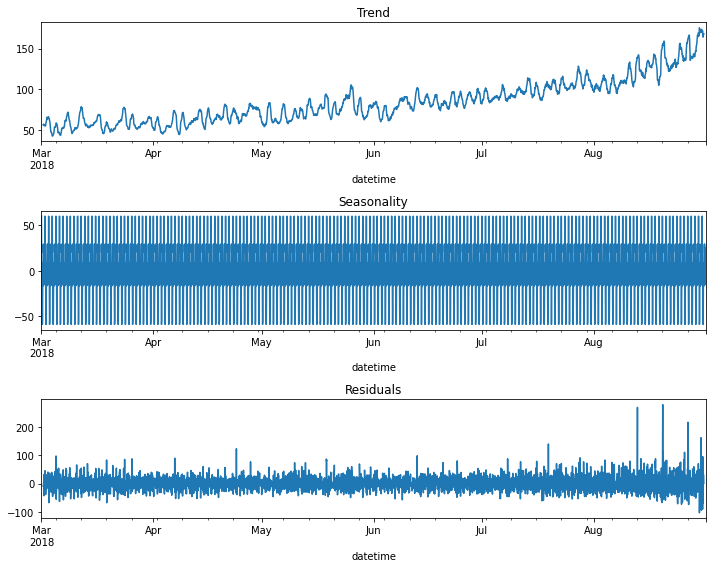

In [61]:
# Применим функцию ко всему датафрейму
plots(df)

По графикам сезонности и остатков сложно сделать какие-либо выводы. По графику тренда видно, что наблюдается восходящий тренд почасовоого количества заявок на протяжении всего анализируемого периода.

Чтобы детальнее увидеть особенности распределения заявок по часам, выберем несколько дней датасета.

In [62]:
df_new = df['2018-08-15':'2018-08-17']

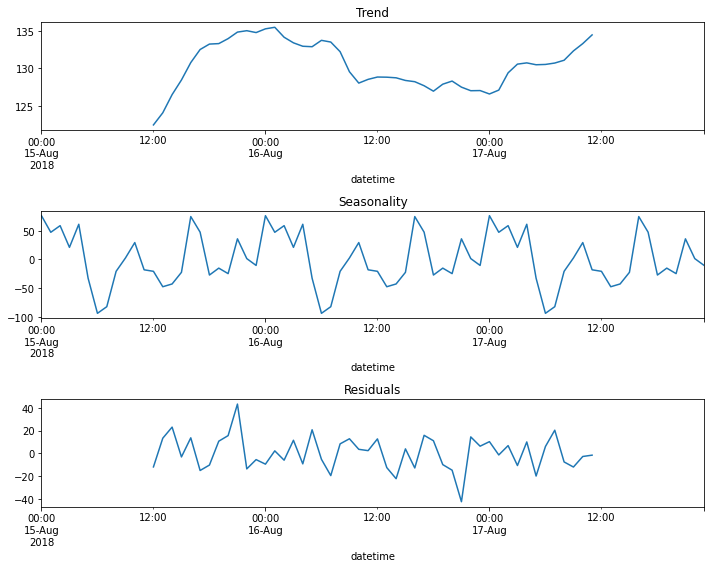

In [63]:
plots(df_new)

На данном интервале можно отследить наибольшую активность клиентов в течение дня. Наибольшее количество заявок наблюдается в вечернее время. Начиная с ночи количество начинает уменьшаться и лишь под утро заявок становтися больше.

В результате анализа удалось установить:

1. У компании наблюдается положительная тенденция роста количества заявок на протяжении всего анализиуемого периода.
2. Наибольшее количество заявок наблюдается в вечернее время, затем с ночи до утра происходит спад, после чего активность клиентов увеличивается.

## Обучение

На данном этапе проведем обучения моделей линейной регрессии, решающего дерева и XGBoost.

Перед началом обучения добавим новые признаки в датасет:

1. каледнарные признаки - year, month, day и dayofweek;
2. отстающие значения - lag;
3. скользящее среднее - rolling_mean.

Напишем функцию make_features, чтобы прибавить к таблице новые признаки.

In [64]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data


In [65]:
new_df = make_features(df, 24, 100)

In [66]:
new_df

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,157.33
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,156.74
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,156.63


Посмотрим на таблицу с новыми признаками.

In [67]:
new_df.head(10)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,2018,3,1,3,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,2018,3,1,3,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,2018,3,1,3,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,2018,3,1,3,15.0,12.0,6.0,43.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Далее необходимо разбить выборку на тестовую и обучающую, а затем выделить фичи и таргет.

In [68]:
train, test = train_test_split(new_df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1) 
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1) 
target_test = test['num_orders']

Так как мы имеем дело с временными рядами, то использовать обычную кросс-валидацию не получится в GridSearch. Поэтому применим TimeSeriesSplit.

In [69]:
# Напишем функцию для вычисления RMSE модели
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
   
# Создадим метрику RMSE с помощью функции make_scorer
RMSE_score = make_scorer(RMSE, greater_is_better=False)

### Модель линейной регрессии

In [70]:
%%time

lnr = LinearRegression()
tss = TimeSeriesSplit(n_splits=3).split(features_train)
lnr.fit(features_train, target_train)
RMSE_lnr = cross_val_score(lnr, features_train, target_train, scoring=RMSE_score, 
                                      cv=tss).mean() * (-1)
print('Среднее значение RMSE модели линейной регрессии равно', RMSE_lnr)

Среднее значение RMSE модели линейной регрессии равно 28.284093719600765
CPU times: user 328 ms, sys: 425 ms, total: 752 ms
Wall time: 705 ms


### Модель решающего дерева

In [71]:
%%time

dtr = DecisionTreeRegressor()
tss = TimeSeriesSplit(n_splits=3).split(features_train)
parametrs = {'criterion':['mse'],
            'max_depth': range(1, 13, 1),
            'random_state': [12345]}
grid_dtr = GridSearchCV(dtr, parametrs, scoring=RMSE_score, cv=tss)
grid_dtr.fit(features_train, target_train)

CPU times: user 1.07 s, sys: 3.47 ms, total: 1.07 s
Wall time: 1.09 s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f515f3d6660>,
             estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['mse'], 'max_depth': range(1, 13),
                         'random_state': [12345]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [72]:
# Выведем результат
grid_dtr.best_params_

{'criterion': 'mse', 'max_depth': 5, 'random_state': 12345}

Лучшая модель получается при максимальной глубине дерева, равной 5.

### Модель XGBoost

In [73]:
%%time

xgb = XGBRegressor()
tss = TimeSeriesSplit(n_splits=3).split(features_train)
parametrs = {'max_depth': range(1, 10, 2),
            'learning_rate':[0.1, 0.3],
            'random_state': [12345],
            'n_estimators': range(10, 50, 10)}
grid_xgb = GridSearchCV(xgb, parametrs, scoring=RMSE_score, cv=tss)
grid_xgb.fit(features_train, target_train)

CPU times: user 23min 10s, sys: 9.08 s, total: 23min 20s
Wall time: 23min 34s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f515221da50>,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_chil...
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                  

In [74]:
# Выведем результат
grid_xgb.best_params_

{'learning_rate': 0.3,
 'max_depth': 3,
 'n_estimators': 20,
 'random_state': 12345}

Лучшая модель получается при learning_rate = 0.3, max_depth = 3 и n_estimators = 20.

На данном этапе были выбраны три модели: линейной регрессии, решающего дерева и XGBoost. Для последних двух моделей были подобраны оптимальные гиперпараметры, которые мы используем на следующем этапе для проверки на тестовой выборке.

## Тестирование

### Модель линейной регрессии

Проверим модель линейной регрессии на тестовой выборке.

In [211]:
%%time

lnr =LinearRegression()
lnr.fit(features_train, target_train)
pred_lnr = lnr.predict(features_test)
print('RMSE модели линейной регрессии =', round(RMSE(target_test, pred_lnr), 2))

RMSE модели линейной регрессии = 47.07
CPU times: user 25.1 ms, sys: 63.2 ms, total: 88.3 ms
Wall time: 74.6 ms


### Модель решающего дерева

In [212]:
%%time

dtr =DecisionTreeRegressor(max_depth=5, criterion='mse', random_state=12345)
dtr.fit(features_train, target_train)
pred_dtr = dtr.predict(features_test)
print('RMSE модели решающего дерева =', round(RMSE(target_test, pred_dtr), 2))

RMSE модели решающего дерева = 55.53
CPU times: user 49.9 ms, sys: 0 ns, total: 49.9 ms
Wall time: 47.7 ms


### Модель XGBoost

In [213]:
%%time

xgb = XGBRegressor(max_depth=3, learning_rate=0.3, random_state=12345, n_estimators=20)
xgb.fit(features_train, target_train)
pred_xgb = xgb.predict(features_test)
print('RMSE модели XGBoost =', round(RMSE(target_test, pred_xgb), 2))

RMSE модели XGBoost = 46.56
CPU times: user 11.8 s, sys: 42 ms, total: 11.8 s
Wall time: 11.8 s


### Сравнение графиков

In [214]:
# Преобразываем наши предсказания в Series
pred_lnr = pd.Series(pred_lnr, index=target_test.index)
pred_dtr = pd.Series(pred_dtr, index=target_test.index)
pred_xgb = pd.Series(pred_xgb, index=target_test.index)

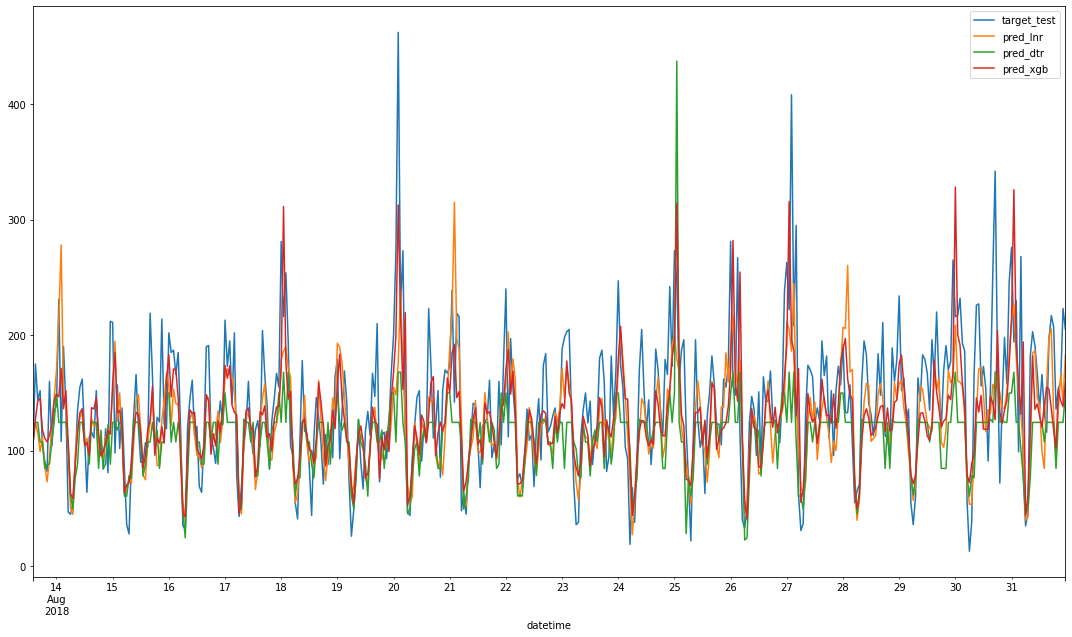

In [234]:
# Построим графики исходного ряда и предсказаний
fig, ax = plt.subplots()
target_test.plot(x='datetime')
pred_lnr.plot(x='datetime')
pred_dtr.plot(x='datetime')
pred_xgb.plot(x='datetime')
plt.legend(["target_test", "pred_lnr", "pred_dtr", "pred_xgb"])
fig.set_size_inches(18.5, 10.5)
plt.show()

**Вывод**

Наименьший показатель среднеквадратической ошибки получился у модели линейной регрессии - 47.07 и у модели XGBoost - 46.56. Так как разность в значения небольшая, выберем модель линейной регрессии, так как она намного быстрее градиентного бустинга. Скорее всего данная модель продемонстрировала хороший результат, так как на графике временных рядов заказов такси наблюдается положительный тренд без сильных колебаний. Также стоит отметить, что наибольшее количество заказов такси наблюдается в вечернее время, затем с ночи до утра количество заказов минимальное.

Руководством компании было задание достигнуть величины RMSE не более 48, что было выполнено в процессе выполнения задания.